### Imports

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


### Loading in Dataset

In [ ]:
data = pd.read_csv('FinalDataset.csv')
data.TWEET=data.TWEET.astype(str)

data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14594, 4)


,Unnamed: 0,TWEET,SCORE,SENTIMENT_LABEL
0,4214,song mileya mileya happi end veri underr nan,1,neutral
1,12011,jai sri ram aapki mehnat oor lagan oor tapesya...,2,positive
2,4848,congratul sir aasha h ab aap capf jism crpf b ...,2,positive
3,9155,jo apn bhai ko ek sit na de ska wo ?????? biha...,0,negative
4,14202,schlag jana heut von mir dank lg nan,1,neutral


In [ ]:
data = data[['TWEET', 'SENTIMENT_LABEL']]
data.head()

,TWEET,SENTIMENT_LABEL
0,song mileya mileya happi end veri underr nan,neutral
1,jai sri ram aapki mehnat oor lagan oor tapesya...,positive
2,congratul sir aasha h ab aap capf jism crpf b ...,positive
3,jo apn bhai ko ek sit na de ska wo ?????? biha...,negative
4,schlag jana heut von mir dank lg nan,neutral


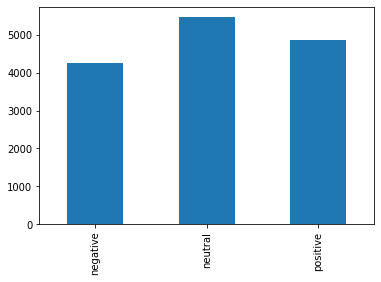

In [ ]:
data['SENTIMENT_LABEL'].value_counts().sort_index().plot.bar()

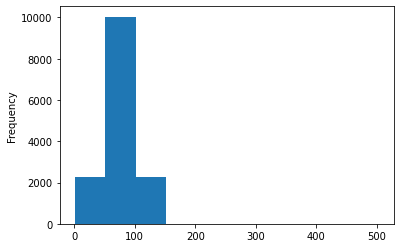

In [ ]:
#data['TWEET'].str.len().plot.hist()

### Preprocessing

In [ ]:
#Transform text to lowercase
data['TWEET'].apply(lambda x: x.lower()) 
#Removing all punctuations and special characters
data['TWEET'] = data['TWEET'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['TWEET'].head()

0         song mileya mileya happi end veri underr nan
1    jai sri ram aapki mehnat oor lagan oor tapesya...
2    congratul sir aasha h ab aap capf jism crpf b ...
3    jo apn bhai ko ek sit na de ska wo  bihar ko k...
4                 schlag jana heut von mir dank lg nan
Name: TWEET, dtype: object

In [ ]:
english_stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
hindi_stopwords = ['ke', 'ka', 'ek', 'mein', 'ki', 'hai', 'yah', 'aur', 'se', 'hain', 'ko', 'par', 'iss', 'hota', 'jo', 'kar', 'me', 'gaya', 'karne', 'kiya', 'liye', 'apne', 'ne', 'bani', 'nahi', 'toh', 'hi', 'ya', 'avam', 'diya', 'ho', 'iska', 'tha', 'dhvara', 'hua', 'tak', 'saath', 'karna', 'vaale', 'baad', 'liya', 'aap', 'kuchh', 'sakte', 'kisi', 'iska', 'sabse', 'ismein', 'the', 'do', 'hone', 'vah', 've', 'karte', 'bahut', 'kaha', 'varg', 'kai', 'karein', 'hoti', 'apni', 'unke', 'thi', 'yadi', 'hui', 'jaa', 'na', 'ise', 'kehte', 'kahte', 'jab', 'hote', 'koi', 'hue', 'va', 'abhi', 'jaise', 'sabhi', 'karta', 'unki', 'tarah', 'uss', 'aadi', 'kul', 'raha', 'iski', 'sakta', 'rahe', 'unka', 'issi', 'rakhein', 'apna', 'pe', 'uske', 'kyu', 'kyun', 'modi', 'isko', 'iska', 'tum', 'tumhara', 'kyon', 'kyunki', 'log', 'bhai', 'kya', 'teri', 'tere', 'tera', 'ab', 'ye', 'yeh', 'ekto', 'aapko', 'ha', 'haan', 'aapka', 'yahi', 'meri', 'mera', 'h', 'u', 'k', 'pr', 'jise', 'jis', 'jisko', 'ham', 'hum', 'hamara', 'humara', 'hamari', 'humari', 'jitna', 'jitne', 'ur', 'wo', 'woh', 'waha', 'wahan', 'vaha', 'vahan', 'kya', 'koh', 'tumne', 'tumn', 'raha', 'rha', 'raho', 'kahun', 'kahu', 'kahan', 'kaha', 'jesi', 'jaisa', 'jaise', 'kitna', 'kitne', 'kitn', 'kitni', 'wale', 'wala', 'didi', 'bhi', 'phir', 'vapas', 'hei', 'hein', 'bana', 'sakte', 'ji', 'n', 'b', 'kisko', 'kisiko', 'apni', 'apna', 'apne', 'hote', 'hota', 'baad', 'mei', 'p', 'ap', 'oye', 'hoye', 'rahe', 'rahi', 'sab', 'apn', 'yhi', 'tmko', 'hu', 'kyonki', 'mere', 'g', 'apka', 'apke', 'apki', 'aapki', 'aapke', 'kaun', 'kab', 'kabhi', 'mai', 'dia', 'lia', 'baat', 'bat', 'hona', 'honi', 'chahiye', 'chahie', 'din', 'saal', 'samay', 'lekin', 'unhe', 'iske', 'gaye', 'gayi']
stopwords_list = english_stopwords + hindi_stopwords
data['TWEET'] = data['TWEET'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

In [ ]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['TWEET'].values)

X = tokenizer.texts_to_sequences(data['TWEET'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   83, 4914, 4914,    9,
         615,  188, 3571,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### Creating model

In [ ]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 81, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 81, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y = pd.get_dummies(data['SENTIMENT_LABEL']).values
[print(data['SENTIMENT_LABEL'][i], y[i]) for i in range(0,5)]

neutral [0 1 0]
positive [0 0 1]
positive [0 0 1]
negative [1 0 0]
neutral [0 1 0]


[None, None, None, None, None]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [13]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
365/365 - 437s - loss: 0.9105 - accuracy: 0.5469
Epoch 2/8
365/365 - 431s - loss: 0.7349 - accuracy: 0.6744
Epoch 3/8
365/365 - 430s - loss: 0.6302 - accuracy: 0.7375
Epoch 4/8
365/365 - 431s - loss: 0.5374 - accuracy: 0.7836
Epoch 5/8
365/365 - 431s - loss: 0.4332 - accuracy: 0.8308
Epoch 6/8
365/365 - 430s - loss: 0.3533 - accuracy: 0.8645
Epoch 7/8
365/365 - 429s - loss: 0.2885 - accuracy: 0.8917
Epoch 8/8
365/365 - 427s - loss: 0.2370 - accuracy: 0.9101


In [14]:
model.save('sentiment_analysis.h5')

### Testing model

In [15]:
predictions = model.predict(X_test)

[print(data['TWEET'][i], predictions[i], y_test[i]) for i in range(0, 5)]

song mileya mileya happi end veri underr nan [1.1327741e-04 1.1130107e-02 9.8875660e-01] [0 0 1]
jai sri ram mehnat oor lagan oor tapesya sri ram je daya drasiti sadev rahegi janta [7.831055e-05 8.260944e-03 9.916608e-01] [0 0 1]
congratul sir aasha capf jism crpf aati jisn aapk kahe anusar bengal [6.3124030e-06 2.1611582e-03 9.9783248e-01] [0 0 1]
sit de ska bihar dega evm gyan jindagi bhar boot [1.0921593e-04 1.7850123e-02 9.8204064e-01] [0 0 1]
schlag jana heut von mir dank lg nan [0.00314967 0.1881996  0.80865073] [0 1 0]


[None, None, None, None, None]

In [16]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 1006
Neutral predictions: 995
Negative predictions: 918
Real positive: 963
Real neutral: 1105
Real negative: 851
